# Binary Stochastic Neurons in Tensorflow

###### A notebook and blog post by [R2RT](http://r2rt.com/)

In this post, I introduce and discuss binary stochastic neurons, implement trainable binary stochastic neurons in Tensorflow, and conduct several simple experiments on the MNIST dataset to get a feel for their behavior. Binary stochastic neurons offer two advantages over real-valued neurons: they can act as a regularizer and they enable conditional computation by enabling a network to make yes/no decisions. Conditional computation opens the door to new and exciting neural network architectures, such as the choice of experts architecture and heirarchical multiscale neural networks, which I plan to discuss in future posts.

### The binary stochastic neuron

A binary stochastic neuron is a neuron with a noisy output: some proportion $p$ of the time it outputs 1, otherwise 0. An easy way to turn a real-valued input, $a$, into this proportion, $p$, is to set $p = \text{sigm}(a)$, where $\text{sigm}$ is the logistic sigmoid, $\text{sigm}(x) = \frac{1}{1 + \exp(-x)}$. Thus, we define the binary stochastic neuron, $\text{BSN}$, as:

$$\text{BSN}(a) = \textbf{1}_{z\ \lt\ \text{sigm}(a)}$$

where $\textbf{1}_{x}$ is the [indicator function](https://en.wikipedia.org/wiki/Indicator_function) on the truth value of $x$ and $z \sim U[0,1]$.


### Advantages of the binary stochastic neuron

1. A binary stochastic neuron is a noisy modification of the logistic sigmoid: instead of outputting $p$, it outputs 1 with probability $p$ and 0 otherwise. Noise generally serves as a regularizer (see, e.g., [Srivastava et al. (2014)](http://www.jmlr.org/papers/v15/srivastava14a.html) and [Neelakantan et al. (2015)](https://arxiv.org/abs/1511.06807)), and so we might expect the same from binary stochastic neurons as compared to the logistic neurons. Indeed, this is the claimed "unpublished result" from the end of [Hinton et al.'s Coursera Lecture 9c](https://www.youtube.com/watch?v=LN0xtUuJsEI&list=PLoRl3Ht4JOcdU872GhiYWf6jwrk_SNhz9&index=41), which I test empirically in this post. Unfortunately, the results below show that binary stochastic neurons do not work so well as regularizers on the MNIST dataset, though they may serve as viable regularizers in other cases.

2. More importantly, by enabling networks to make binary decisions, the binary stochastic neuron allows for conditional computation. This opens the door to some interesting new architectures. For example, instead of a mixture of experts architecture, which weights the outputs of several "expert" sub-networks and requires that all subnetworks be computed, we could use a *choice* of experts architecture, which conditionally uses expert sub-networks as needed. This architecture is implicitly proposed in [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432), wherein the experiments use a choice of expert units architecture (i.e., a gated architecture where gates must be 1 or 0). Another example, proposed in [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432) and implemented by [Chung et al. (2016)](https://arxiv.org/abs/1609.01704), is the Heirarchical Multiscale Recurrent Neural Network (HM-RNN) architecture, which achieves great results on language modelling tasks. Both of these architectures will be explored in future posts.

### Training the binary stochastic neuron

For any single trial, the binary stochastic neuron generally has a derivative of 0 and cannot be trained by simple backpropagation. To see this, consider that if $z \neq \text{sigm}(a)$ in the $\text{BSN}$ function above, there exists a [neighborhood](https://en.wikipedia.org/wiki/Neighbourhood_(mathematics)) around $a$ such that the output of $\text{BSN}(a)$ is unchanged (i.e., the derivative is 0). We get around this by *estimating* the derivative with respect to the *expected* loss, rather than calculating the derivative with respect to the outcome of a single trial. We can only estimate this derivative, because in any given trial, we only see the loss value with respect to the given noise -- we don't know what the loss would have been given another level of noise. We call a method that provides such an estimate an "estimator". An estimator is *unbiased* if the expectation of its estimate equals the expectation of the derivative it is estimating; otherwise, it is *biased*.

In this post we implement the two estimators discussed in [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432):

1. The REINFORCE estimator, which is an unbiased estimator and a special case of the REINFORCE algorithm discussed in [Williams (1992)](http://link.springer.com/article/10.1007/BF00992696).

    The REINFORCE estimator estimates the expectation of $\frac{\partial L}{\partial a}$ as $(\text{BSN}(a) - \text{sigm}(a))(L - c)$, where $c$ is a constant. [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432) proves that:

    $$\mathbb{E}[(\text{BSN}(a) - \text{sigm}(a))(L - c)] = \mathbb{E}\big[\frac{\partial L}{\partial a}\big].$$

    [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432) further shows that to minimize the variance of the estimation, we choose:

    $$c = \bar L = \frac{\mathbb{E}[\text{BSN}(a) - \text{sigm}(a))^2L]}{\mathbb{E}[\text{BSN}(a) - \text{sigm}(a))^2]}$$

    which we can practically implement by keeping track of the numerator and denominator as a moving average. Interestingly, the REINFORCE estimator does not require any backpropagated loss gradient--it operates directly on the loss of the network.

2. The straight through (ST) estimator, which is a biased estimator that was first proposed by [Hinton et al.'s Coursera Lecture 9c](https://www.youtube.com/watch?v=LN0xtUuJsEI&list=PLoRl3Ht4JOcdU872GhiYWf6jwrk_SNhz9&index=41).

    The ST estimator simply replaces the derivative factor used during backpropagation, $\frac{d\text{BSN}(a)}{da} = 0$, with $\frac{d\text{BSN}(a)}{da} = \text{BSN}(a)$. A variant of the ST estimator replaces the derivative factor with $\frac{d\text{BSN}(a)}{da} = \text{sigm}(a)$. Whereas [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432) found that the former is more effective, the latter variant was successfully used in [Chung et al. (2016)](https://arxiv.org/abs/1609.01704) in combination with the *slope-annealing trick* and deterministic binary neurons (which we will see perform very similarly, if not better, than stochastic binary neurons when used with slope-annealing). The slope-anealing trick modifies $\text{BSN}(a)$ by first multiplying the input $a$ by a slope $m$ as follows:

    $$\text{BSN}_{\text{SL}(m)}(a) = \textbf{1}_{z \gt \text{sigm}(ma)}.$$

    Then, we increase the slope as training progresses and use $\frac{d\text{BSN}(a)}{da} = \text{sigm}(ma)$ when computing the gradient. The idea behind this is that as the slope increases, the logistic sigmoid approaches a step function, so that it's derivative approaches the true derivative. All three variants are tested in this post.

### Implementing the binary stochastic neuron in Tensorflow

The tricky part of implementing a binary stochastic neuron in Tensorflow is not the forward computation, but the implementation of the REINFORCE and straight through estimators. Each requires replacing the gradient of one or more Tensorflow operations. The [official approach](https://www.tensorflow.org/versions/r0.10/how_tos/adding_an_op/index.html) to this is to write a new op in C++, which seems wholly unnecessary. There are, however, two workable unofficial approaches, one of which is [a trick credited to Sergey Ioffe](http://stackoverflow.com/questions/36456436/how-can-i-define-only-the-gradient-for-a-tensorflow-subgraph/36480182), and another that uses `gradient_override_map`, an experimental feature of Tensorflow that is documented [here](https://www.tensorflow.org/versions/r0.10/api_docs/python/framework.html). We will use `gradient_override_map`, which works well for our purposes.

#### Imports and Utility Functions

In [1]:
   
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
from tensorflow.python.framework import ops
from enum import Enum
import seaborn as sns
sns.set(color_codes=True)

def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()
    
def layer_linear(inputs, shape, scope='linear_layer'):
    with tf.variable_scope(scope):
        w = tf.get_variable('w',shape)
        b = tf.get_variable('b',shape[-1:])
    return tf.matmul(inputs,w) + b

def layer_softmax(inputs, shape, scope='softmax_layer'):
    with tf.variable_scope(scope):
        w = tf.get_variable('w',shape)
        b = tf.get_variable('b',shape[-1:])
    return tf.nn.softmax(tf.matmul(inputs,w) + b)

def accuracy(y, pred):
    correct = tf.equal(tf.argmax(y,1), tf.argmax(pred,1))
    return tf.reduce_mean(tf.cast(correct, tf.float32))

def plot_n(data_and_labels, lower_y = 0., title="Learning Curves"):
    fig, ax = plt.subplots()
    for data, label in data_and_labels:
        ax.plot(range(0,len(data)*100,100),data, label=label)
    ax.set_xlabel('Training steps')
    ax.set_ylabel('Accuracy')
    ax.set_ylim([lower_y,1])
    ax.set_title(title)
    ax.legend(loc=4)
    plt.show()
    
class StochasticGradientEstimator(Enum):
    ST = 0
    REINFORCE = 1   
    
    
    
print('OK!!!!')    

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
OK!!!!


#### Binary stochastic neuron with straight through estimator

In [2]:
def binaryRound(x):
    """
    Rounds a tensor whose values are in [0,1] to a tensor with values in {0, 1}, 
    using the straight through estimator for the gradient.
    
    E.g.,:
    If x is >= 0.5, binaryRound(x) will be 1 and the gradient will be pass-through,
    otherwise, binaryRound(x) will be 0 and the gradient will be 0.
    """
    g = tf.get_default_graph()
    
    with ops.name_scope("BinaryRound") as name:
        # override "Floor" because tf.round uses tf.floor
        with g.gradient_override_map({"Floor": "BinaryRound"}):
            return tf.round(x, name=name)
        
@ops.RegisterGradient("BinaryRound")
def _binaryRound(op, grad):
    """Straight through estimator for the binaryRound op (identity if 1, else 0)."""
    x = op.outputs[0]
    return x * grad

In [3]:
def bernoulliSample(x):
    """
    Uses a tensor whose values are in [0,1] to sample a tensor with values in {0, 1},
    using the straight through estimator for the gradient.
    
    E.g.,:
    if x is 0.6, bernoulliSample(x) will be 1 with probability 0.6, and 0 otherwise,
    and the gradient will be pass-through (1) wih probability 0.6, and 0 otherwise. 
    """
    g = tf.get_default_graph()
    
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)
        
@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    """Straight through estimator for the bernoulliSample op (identity if 1, else 0)."""
    sub = op.outputs[0] # x - tf.random_uniform... 
    res = sub.consumers()[0].outputs[0] # tf.ceil(sub)
    return [res * grad, tf.zeros(tf.shape(op.inputs[1]))]

In [4]:
def passThroughSigmoid(x, slope=1):
    """Sigmoid that uses identity function as its gradient"""
    g = tf.get_default_graph()
    with ops.name_scope("PassThroughSigmoid") as name:
        with g.gradient_override_map({"Sigmoid": "Identity"}):
            return tf.sigmoid(x, name=name)
        
def binaryStochastic_ST(x, slope_tensor=None, pass_through=True, stochastic=True):
    """
    Sigmoid followed by either a random sample from a bernoulli distribution according 
    to the result (binary stochastic neuron) (default), or a sigmoid followed by a binary
    step function (if stochastic == False). Uses the straight through estimator. 
    See https://arxiv.org/abs/1308.3432.
    
    Arguments:
    * x: the pre-activation / logit tensor
    * slope_tensor: if passThrough==False, slope adjusts the slope of the sigmoid function 
        for purposes of the Slope Annealing Trick (see http://arxiv.org/abs/1609.01704)
    * pass_through: if True (default), gradient of the entire function is 1 or 0; 
        if False, gradient of 1 is scaled by the gradient of the sigmoid (required if
        Slope Annealing Trick is used)
    * stochastic: binary stochastic neuron if True (default), or step function if False
    """
    if slope_tensor is None:
        slope_tensor = tf.constant(1.0)
        
    if pass_through:
        p = passThroughSigmoid(x)
    else:
        p = tf.sigmoid(slope_tensor*x)
    
    if stochastic:
        return bernoulliSample(p)
    else:
        return binaryRound(p)

#### Binary stochastic neuron with REINFORCE estimator

In [5]:
def binaryStochastic_REINFORCE(x, stochastic = True, loss_op_name="loss_by_example"):
    """
    Sigmoid followed by a random sample from a bernoulli distribution according
    to the result (binary stochastic neuron). Uses the REINFORCE estimator.
    See https://arxiv.org/abs/1308.3432.
    
    NOTE: Requires a loss operation with name matching the argument for loss_op_name 
    in the graph. This loss operation should be broken out by example (i.e., not a
    single number for the entire batch).
    """
    g = tf.get_default_graph()

    with ops.name_scope("BinaryStochasticREINFORCE"):    
        with g.gradient_override_map({"Sigmoid": "BinaryStochastic_REINFORCE", 
                                      "Ceil": "Identity"}):
            p = tf.sigmoid(x)
            
            reinforce_collection = g.get_collection("REINFORCE")
            if not reinforce_collection:
                g.add_to_collection("REINFORCE", {})
                reinforce_collection = g.get_collection("REINFORCE")
            reinforce_collection[0][p.op.name] = loss_op_name
            
            return tf.ceil(p - tf.random_uniform(tf.shape(x)))

            
@ops.RegisterGradient("BinaryStochastic_REINFORCE")
def _binaryStochastic_REINFORCE(op, _):
    """Unbiased estimator for binary stochastic function based on REINFORCE."""
    loss_op_name = op.graph.get_collection("REINFORCE")[0][op.name]
    loss_tensor = op.graph.get_operation_by_name(loss_op_name).outputs[0]
    
    sub_tensor = op.outputs[0].consumers()[0].outputs[0] #subtraction tensor
    ceil_tensor = sub_tensor.consumers()[0].outputs[0] #ceiling tensor
    
    outcome_diff = (ceil_tensor - op.outputs[0])
    
    # Provides an early out if we want to avoid variance adjustment for
    # whatever reason (e.g., to show that variance adjustment helps)
    if op.graph.get_collection("REINFORCE")[0].get("no_variance_adj"):
        return outcome_diff * tf.expand_dims(loss_tensor, 1)
    
    outcome_diff_sq = tf.square(outcome_diff)
    outcome_diff_sq_r = tf.reduce_mean(outcome_diff_sq, reduction_indices=0)
    outcome_diff_sq_loss_r = tf.reduce_mean(outcome_diff_sq * tf.expand_dims(loss_tensor, 1),
                                            reduction_indices=0)
    
    L_bar_num = tf.Variable(tf.zeros(outcome_diff_sq_r.get_shape()), trainable=False)
    L_bar_den = tf.Variable(tf.ones(outcome_diff_sq_r.get_shape()), trainable=False)
    
    #Note: we already get a decent estimate of the average from the minibatch
    decay = 0.95 
    train_L_bar_num = tf.assign(L_bar_num, L_bar_num*decay +\
                                            outcome_diff_sq_loss_r*(1-decay))
    train_L_bar_den = tf.assign(L_bar_den, L_bar_den*decay +\
                                            outcome_diff_sq_r*(1-decay))


    with tf.control_dependencies([train_L_bar_num, train_L_bar_den]):   
        L_bar = train_L_bar_num/(train_L_bar_den+1e-4)
        L = tf.tile(tf.expand_dims(loss_tensor,1),
                    tf.constant([1,L_bar.get_shape().as_list()[0]]))
        return outcome_diff * (L - L_bar)

#### Wrapper to create layer of binary stochastic neurons

In [6]:
def binary_wrapper(\
                pre_activations_tensor,
                estimator=StochasticGradientEstimator.ST,
                stochastic_tensor=tf.constant(True), 
                pass_through=True, 
                slope_tensor=tf.constant(1.0)):
    """
    Turns a layer of pre-activations (logits) into a layer of binary stochastic neurons
    
    Keyword arguments:
    *estimator: either ST or REINFORCE
    *stochastic_tensor: a boolean tensor indicating whether to sample from a bernoulli 
        distribution (True, default) or use a step_function (e.g., for inference)
    *pass_through: for ST only - boolean as to whether to substitute identity derivative on the 
        backprop (True, default), or whether to use the derivative of the sigmoid
    *slope_tensor: for ST only - tensor specifying the slope for purposes of slope annealing
        trick
    """
    
    if estimator == StochasticGradientEstimator.ST:
        if pass_through:
            return tf.cond(stochastic_tensor, 
                    lambda: binaryStochastic_ST(pre_activations_tensor), 
                    lambda: binaryStochastic_ST(pre_activations_tensor, stochastic=False))  
        else:
            return tf.cond(stochastic_tensor, 
                    lambda: binaryStochastic_ST(pre_activations_tensor, slope_tensor = slope_tensor, 
                                             pass_through=False), 
                    lambda: binaryStochastic_ST(pre_activations_tensor, slope_tensor = slope_tensor, 
                                             pass_through=False, stochastic=False))
    elif estimator == StochasticGradientEstimator.REINFORCE:
        # binaryStochastic_REINFORCE was designed to only be stochastic, so using the ST version
        # for the step fn for purposes of using step fn at evaluation / not for training
        return tf.cond(stochastic_tensor,
                lambda: binaryStochastic_REINFORCE(pre_activations_tensor),
                lambda: binaryStochastic_ST(pre_activations_tensor, stochastic=False))
    
    else:
        raise ValueError("Unrecognized estimator.")

#### Function to build graph for MNIST classifier

In [7]:
def build_classifier(hidden_dims=[100], 
                        lr = 0.5, 
                        pass_through = True, 
                        non_binary = False, 
                        estimator = StochasticGradientEstimator.ST,
                        no_var_adj=False):
    reset_graph()
    g = {}
    
    if no_var_adj:
        tf.get_default_graph().add_to_collection("REINFORCE", {"no_variance_adj": no_var_adj})

    g['x'] = tf.placeholder(tf.float32, [None, 784], name='x_placeholder')
    g['y'] = tf.placeholder(tf.float32, [None, 10], name='y_placeholder')
    g['stochastic'] = tf.constant(True)
    g['slope'] = tf.constant(1.0)
    
    g['layers'] = {0: g['x']}
    hidden_layers = len(hidden_dims)
    dims = [784] + hidden_dims
    
    for i in range(1, hidden_layers+1):
        with tf.variable_scope("layer_" + str(i)):
            pre_activations = layer_linear(g['layers'][i-1], dims[i-1:i+1], scope='layer_' + str(i))
            if non_binary:
                g['layers'][i] = tf.sigmoid(pre_activations)
            else:
                g['layers'][i] = binary_wrapper(pre_activations, 
                                              estimator = estimator,
                                              pass_through = pass_through, 
                                              stochastic_tensor = g['stochastic'], 
                                              slope_tensor = g['slope'])
    
    g['pred'] = layer_softmax(g['layers'][hidden_layers], [dims[-1], 10])
    
    g['loss'] = -tf.reduce_mean(g['y'] * tf.log(g['pred']),reduction_indices=1)
    
    # named loss_by_example necessary for REINFORCE estimator
    tf.identity(g['loss'], name="loss_by_example") 
    
    g['ts'] = tf.train.GradientDescentOptimizer(lr).minimize(g['loss'])

    g['accuracy'] = accuracy(g['y'], g['pred'])
    return g

#### Function to train the classifier

In [8]:
def train_classifier(\
        hidden_dims=[100,100],
        estimator=StochasticGradientEstimator.ST,
        stochastic_train=True, 
        stochastic_eval=True, 
        slope_annealing_rate=None, 
        epochs=10, 
        lr=0.5,
        non_binary=False,
        no_var_adj=False,
        train_set = mnist.train,
        val_set = mnist.validation,
        verbose=False,
        label=None):
    if slope_annealing_rate is None:
        g = build_classifier(hidden_dims=hidden_dims, lr=lr, pass_through=True, 
                                non_binary=non_binary, estimator=estimator, no_var_adj=no_var_adj)
    else:
        g = build_classifier(hidden_dims=hidden_dims, lr=lr, pass_through=False, 
                                non_binary=non_binary, estimator=estimator, no_var_adj=no_var_adj)
        
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
        slope = 1
        res_tr, res_val = [], []
        for epoch in range(epochs):        
            feed_dict={g['x']: val_set.images, 
                       g['y']: val_set.labels, 
                       g['stochastic']: stochastic_eval,
                       g['slope']: slope}
            if verbose:
                print("Epoch", epoch, sess.run(g['accuracy'], feed_dict=feed_dict))

            accuracy = 0
            for i in range(1001):
                x, y = train_set.next_batch(50)
                feed_dict={g['x']: x, g['y']: y, g['stochastic']: stochastic_train}
                acc, _ = sess.run([g['accuracy'],g['ts']], feed_dict=feed_dict)
                accuracy += acc
                if i % 100 == 0 and i > 0:
                    res_tr.append(accuracy/100)
                    accuracy = 0
                    feed_dict={g['x']: val_set.images, 
                               g['y']: val_set.labels, 
                               g['stochastic']: stochastic_eval,
                               g['slope']: slope}
                    res_val.append(sess.run(g['accuracy'], feed_dict=feed_dict))                

            if slope_annealing_rate is not None:
                slope = slope*slope_annealing_rate
                if verbose:
                    print("Sigmoid slope:", slope)

        feed_dict={g['x']: val_set.images, g['y']: val_set.labels, 
                   g['stochastic']: stochastic_eval, g['slope']: slope}
        print("Epoch", epoch+1, sess.run(g['accuracy'], feed_dict=feed_dict))
        if label is not None:
            return (res_tr, label + " - Training"), (res_val, label + " - Validation")
        else:
            return [(res_tr, "Training"), (res_val, "Validation")]

### Experiments

We've now set up a good foundation from which we can run a number of simple experiments. The experiments are as follows:

- **Experiment 0**: A non-stochastic, non-binary baseline.
- **Experiment 1**: A comparison of variance-adjusted REINFORCE and non-variance adjusted REINFORCE, which shows that the variance adjustment allows for faster learning and higher learning rates.
- **Experiment 2**: A comparison of pass-through ST and sigmoid-adjusted ST, which shows that the pass-through ST estimator obtains better results, in accordance with the findings of [Bengio et al. (2013](https://arxiv.org/abs/1308.3432). 
- **Experiment 3**: A comparison of pass-through ST and slope-annealed sigmoid-adjusted ST, which shows that a well-tuned slope-annealed ST performs slightly better than the pass-through ST.
- **Experiment 4**: A direct comparison of variance-adjusted REINFORCE and slope-annealed ST, which shows that ST performs significantly better than REINFORCE.
- **Experiment 5**: A look at the deterministic step function, during training and evaluation, which shows that in the absence of slope annealing, stochasticity is necessary during training, but that deterministic evaluation can provide a slight boost at inference, and that with slope annealing, deterministic training is just as effective, if not more effective than stochastic training.
- **Experiment 6**: A look at how network depth affects performance, which shows that deep stochastic networks are difficult to train. 
- **Experiment 7**: A look at using binary stochastic neurons as a regularizer, which shows that they do function as a regularizer, but it is unclear whether it is worthwhile to use them as one. 

#### Experiment 0: A non-stochastic, non-binary baseline

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.96319973)


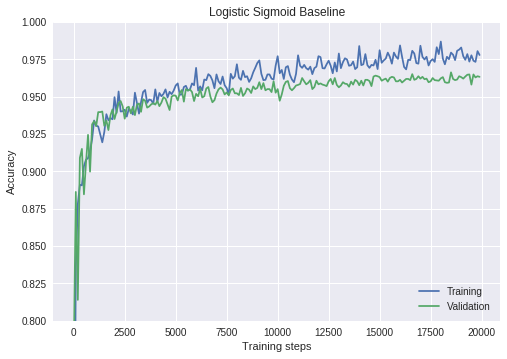

In [9]:
res = train_classifier(hidden_dims=[100], epochs=20, lr=1.0, non_binary=True)
plot_n(res, lower_y=0.8, title="Logistic Sigmoid Baseline")

#### Experiment 1: Variance-adjusted vs. not variance-adjusted REINFORCE

Recall that the REINFORCE estimator estimates the expectation of $\frac{\partial L}{\partial a}$ as $(\text{BSN}(a) - \text{sigm}(a))(L - c)$, where $c$ is a constant. The non-variance-adjusted form of REINFORCE uses $c = 0$, whereas the variance-adjusted form uses the variance minimizing result stated above. Naturally we should prefer the least variance, and the experimental results below agree. 

It seems that both forms of REINFORCE often break down for learning rates greater than or equal to 0.3 (compare to the learning rate of 1.0 that used in Experiment 0). After a few trials, variance-adjusted REINFORCE appears to be more resistant to such failures.

In [10]:
print("Variance-adjusted:")
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=3, 
                       lr=0.3, verbose=True)
print("Not variance-adjusted:")
res2= train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=3, 
                       lr=0.3, no_var_adj=True, verbose=True)

Variance-adjusted:
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 0, 0.088199988)
('Epoch', 1, 0.095799997)
('Epoch', 2, 0.095799997)
('Epoch', 3, 0.095799997)
Not variance-adjusted:
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 0, 0.099600002)
('Epoch', 1, 0.095799997)
('Epoch', 2, 0.095799997)
('Epoch', 3, 0.095799997)


In terms of performance at lower learning rates, a learning rate of about 0.05 provided the best results. The results show that the variance-adjusted REINFORCE learns faster, but that its non-variance adjusted eventually catches up. This result is consistent with the mathematical result that they are both unbiased estimators. Performance is predictably worse than it was for the plain logistic sigmoid in Experiment 0, although there is almost no generalization gap, consistent with the hypothesis that binary stochastic neurons can act as regularizers.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.92299968)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.92079973)


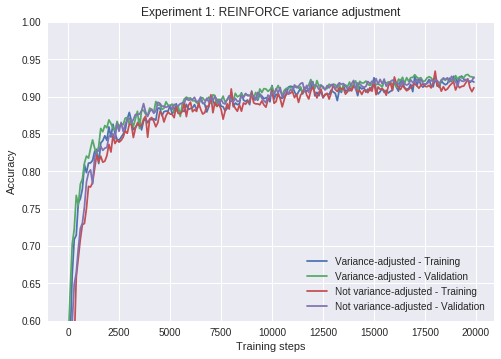

In [11]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, label = "Variance-adjusted")
res2= train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, no_var_adj=True, label = "Not variance-adjusted")

plot_n(res1 + res2, lower_y=0.6, title="Experiment 1: REINFORCE variance adjustment")

#### Experiment 2: Pass-through vs. sigmoid-adjusted ST estimation

Recall that one variant of the straight-through estimator uses the identity function as the backpropagated gradient when the neuron emits a 1 (pass-through), and another variance multiplies that by the gradient of the logistic sigmoid that the neuron calculates (sigmoid-adjusted). In [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432), it was remarked that, surprisingly, the former performs better. My results below agree; we see that the pass-through variant edges out the sigmoid-adjusted variant at higher learning rates, and interestingly, at a learning rate of 1, the sigmoid-adjusted variant performs very poorly and fails to converge.

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.94819969)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.94959968)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.93899971)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.94259977)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.89539981)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.65099984)


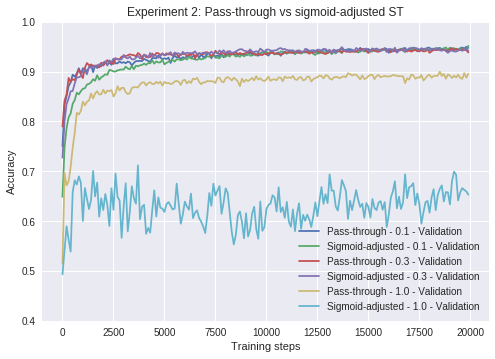

In [12]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.1, label = "Pass-through - 0.1")
res2 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.1, slope_annealing_rate = 1.0, label = "Sigmoid-adjusted - 0.1")

res3 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.3, label = "Pass-through - 0.3")
res4 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.3, slope_annealing_rate = 1.0, label = "Sigmoid-adjusted - 0.3")

res5 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=1.0, label = "Pass-through - 1.0")
res6 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=1.0, slope_annealing_rate = 1.0, label = "Sigmoid-adjusted - 1.0")

plot_n(res1[1:] + res2[1:] + res3[1:] + res4[1:] + res5[1:] + res6[1:], 
       lower_y=0.4, title="Experiment 2: Pass-through vs sigmoid-adjusted ST")

#### Experiment 3: Pass-through vs. slope-annealed ST estimation

Recall that [Chung et al. (2016)](https://arxiv.org/abs/1609.01704) improves upon the sigmoid-adjusted variant of the ST estimator by using the *slope-annealing trick*, which slowly increases the slope of the logistic sigmoid as training progresses. Using the slope-annealing trick with an annealing rate of 1.1 times per epoch (so the slope at epoch 20 is $1.1^{19} \approx 6.1$), we're able to match and even surpass the results of the pass-through ST estimator. The slope-annealed estimator is still more sensitive to the learning rate (performing similarly to the sigmoid-adjusted variant at a learning rate of 1.0), but it appears that it can be fine tuned to perform better than the pass-through variant. Note that the slope annealed neuron used here is not the same as the one used by [Chung et al. (2016)](https://arxiv.org/abs/1609.01704), who employ a deterministic step function and use a hard sigmoid in place of a sigmoid for the backpropagation. 

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.90999979)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.9557997)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.94259971)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.96619976)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.96019971)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.95499969)


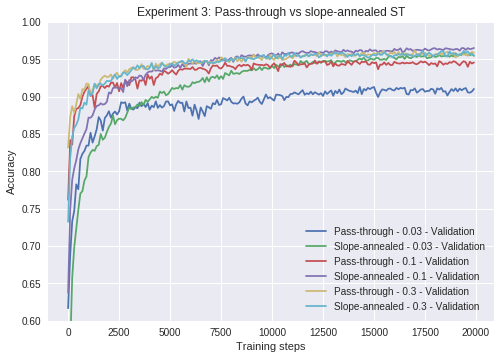

In [13]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.03, label = "Pass-through - 0.03")
res2 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.03, slope_annealing_rate = 1.1, label = "Slope-annealed - 0.03")

res3 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.1, label = "Pass-through - 0.1")
res4 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.1, slope_annealing_rate = 1.1, label = "Slope-annealed - 0.1")

res5 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.3, label = "Pass-through - 0.3")
res6 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.3, slope_annealing_rate = 1.1, label = "Slope-annealed - 0.3")

plot_n(res1[1:] + res2[1:] + res3[1:] + res4[1:] + res5[1:] + res6[1:],
       lower_y=0.6, title="Experiment 3: Pass-through vs slope-annealed ST")

#### Experiment 4: Variance-adjusted REINFORCE vs slope-annealed ST

We now directly compare the variance-adjusted REINFORCE and slope-annealed ST, both at their best learning rates. In this setting, despite being a biased estimator, the straight-through estimator displays faster learning, less variance, and better overall results than the variance-adjusted REINFORCE estimator. 

In [14]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, label = "Variance-adjusted REINFORCE")

res2 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                       lr=0.1, slope_annealing_rate = 1.1, label = "Slope-annealed ST")

plot_n(res1[1:] + res2[1:],
       lower_y=0.6, title="Experiment 4: Variance-adjusted REINFORCE vs slope-annealed ST")

Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 20, 0.92839968)
Instructions for updating:
Use `tf.global_variables_initializer` instead.


KeyboardInterrupt: 

#### Experiment 5: A look at the deterministic step function, during training and evaluation

Similar to how dropout is not applied at inference when using dropout for training, it makes sense that we might replace the stochastic sigmoid with a deterministic step function at inference when using binary neurons. We might go even further than that, and use deterministic neurons during training, which is the approach taken by [Chung et al. (2016)](https://arxiv.org/abs/1609.01704). The following three combinations are compared below, using the pass-through straight through estimator, without slope annealing:

- stochastic during training, stochastic during test
- stochastic during training, deterministic during test
- deterministic during training, deterministic during test

The results show that stochastic inference and deterministic inference, when combined with stochastic training, are closely comparable (with the latter having a slight edge), but that deterministic training lags behind stochastic training. Similar results hold for the REINFORCE estimator.

In [ ]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, label = "Stochastic, Stochastic")
res2 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, stochastic_eval=False, label = "Stochastic, Deterministic")
res3 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, stochastic_train=False, stochastic_eval=False, 
                        label = "Deterministic, Deterministic")

plot_n(res1 + res2 + res3,
       lower_y=0.6, title="Experiment 5: Stochastic vs Deterministic (Straight-through, no slope annealing)")

The introduction of slope annealing, however, as per [Chung et al. (2016)](https://arxiv.org/abs/1609.01704), closes the gap between stochastic and deterministic training. Although stochastic and deterministic training converge to a similar result, deterministic training results in faster training early on. Note that the slope annealed neuron used here is not exactly the same as the one used by [Chung et al. (2016)](https://arxiv.org/abs/1609.01704); this one uses a regular sigmoid, whereas Chung et al. use a hard sigmoid. 

In [ ]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=30, 
                        lr=0.1, slope_annealing_rate=1.1, stochastic_eval=False, 
                        label = "Stochastic, Deterministic (Slope annealed)")
res2 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=30, 
                        lr=0.1, slope_annealing_rate=1.1, stochastic_train=False, stochastic_eval=False, 
                        label = "Deterministic, Deterministic (Slope annealed)")

plot_n(res1[1:] + res2[1:],
       lower_y=0.90, title="Experiment 5: Stochastic vs Deterministic (Straight-through, with slope annealing)")

#### Experiment 6: The effect of depth on REINFORCE and ST estimators

Next, I look at how each estimator interacts with depth. From a theoretical perpective, there is reason to think the straight-through estimator will suffer from depth; as noted by [Bengio et al. (2013)](https://arxiv.org/abs/1308.3432), it is not even guaranteed to have the same sign as the expected gradient during backpropagation. It turns out that if we keep the learning rate constant, both estimators start to fail as we increase depth. However, if we lower the learning rate dramatically (300x for the ST estimator and 25x for the REINFORCE estimator), we can start to get the deeper networks to train. In constrast with the results of earlier experiments, the bias of the straight through estimator starts to show and the REINFORCE estimator is the clear winner at higher depths. 

In [ ]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, label = "1 hidden layer")
res2 = train_classifier(hidden_dims=[100, 100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, label = "2 hidden layers")
res3 = train_classifier(hidden_dims=[100, 100, 100], estimator=StochasticGradientEstimator.ST, epochs=20, 
                        lr=0.3, label = "3 hidden layers")

plot_n(res1[1:] + res2[1:] + res3[1:], title="Experiment 6: The effect of depth (straight-through)")

In [ ]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, label = "1 hidden layer")
res2 = train_classifier(hidden_dims=[100,100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, label = "2 hidden layers")
res3 = train_classifier(hidden_dims=[100,100,100], estimator=StochasticGradientEstimator.REINFORCE, epochs=20, 
                       lr=0.05, label = "3 hidden layers")

plot_n(res1[1:] + res2[1:] + res3[1:], title="Experiment 6: The effect of depth (REINFORCE)")

In [ ]:
res1 = train_classifier(hidden_dims=[100], estimator=StochasticGradientEstimator.ST, epochs=50, 
                        lr=0.001, label = "1 hidden layer")
res2 = train_classifier(hidden_dims=[100, 100], estimator=StochasticGradientEstimator.ST, epochs=50, 
                        lr=0.001, label = "2 hidden layers")
res3 = train_classifier(hidden_dims=[100, 100, 100], estimator=StochasticGradientEstimator.ST, epochs=50, 
                        lr=0.001, label = "3 hidden layers")

plot_n(res1[1:] + res2[1:] + res3[1:], title="Experiment 6: The effect of depth (straight-through) (LR = 0.001)")

In [ ]:
res1 = train_classifier(hidden_dims=[100], epochs=50, non_binary=True, 
                       lr=0.002, label = "1 hidden layer")
res2 = train_classifier(hidden_dims=[100,100], epochs=50, non_binary=True, 
                       lr=0.002, label = "2 hidden layers")
res3 = train_classifier(hidden_dims=[100,100,100], epochs=50, non_binary=True, 
                       lr=0.002, label = "3 hidden layers")

plot_n(res1[1:] + res2[1:] + res3[1:], title="Experiment 6: The effect of depth (REINFORCE) (LR = 0.002)")

#### Experiment 7: Using binary stochastic neurons as a regularizer.

I now test the "unpublished result" put forth at the end of [Hinton et al.'s Coursera Lecture 9c](https://www.youtube.com/watch?v=LN0xtUuJsEI&list=PLoRl3Ht4JOcdU872GhiYWf6jwrk_SNhz9&index=41), which states that we can improve upon the performance of an overfitting multi-layer sigmoid net by turning its neurons binary stochastic neurons with a straight-through estimator. Note that Hinton states that the binary stochastic net might take several times longer to train, which we'll see is true. 

To test the claim, we will need a dataset that is easier to overfit than MNIST, and so the following experiment uses the MNIST validation set for training (10x smaller than the MNIST training set and therefore much easier to overfit). The hidden layer size is also increased by a factor of 10 to increase overfitting. 

It took me quite a bit of playing with hyperparameters to get this result, but we can see below that the stochastic net has a clear advantage in terms of the generalization gap and results in a better final fit. Note that 60 epochs are trained below in order to give the stochastic net time to catch up. When testing with a deeper architecture (i.e., 2 hidden layers), I was able to match but not beat the performance of a sigmoidal network with a stochastic one, and this was after 200 epochs of training. 

Given that I had to run this experiment several times to cook up this result, I see no compelling reason to use binary stochastic neurons over other methods (dropout, weight decay or weight noise) for purposes of regularization.

In [ ]:
res1 = train_classifier(hidden_dims = [1000], epochs=60, train_set=mnist.validation, val_set=mnist.test, 
                        lr = 0.03, non_binary = True, label = "Deterministic sigmoid net")

res2 = train_classifier(hidden_dims = [1000], epochs=60, stochastic_eval=False, train_set=mnist.validation, 
                        val_set=mnist.test, slope_annealing_rate=1.05, estimator=StochasticGradientEstimator.ST, 
                        lr = 0.01, label = "Binary stochastic net")

plot_n(res1 + res2, lower_y=0.8, title="Experiment 8: Using binary stochastic neurons as a regularizer")

### Conclusion

In this post we introduced, implemented and experimented with binary stochastic neurons in Tensorflow. We saw that with a single binary stochastic layer, the biased straight-through estimator outperforms the unbiased REINFORCE estimator, but that with deeper stochastic architectures, the REINFORCE estimator does better. We explored the variants of each estimator, and showed that the slope-annealed straight through estimator is better than other straight through variants, and that it is worth using the variance-adjusted REINFORCE estimator over the not variance-adjusted REINFORCE estimator. Finally, we explored the potential use for binary stochastic neurons as regularizers, and concluded that it is probably not worth the effort. 

In future posts, I will look we can take advantage of binary stochastic neurons to make hard decisions within our neural network architecture. This opens the door to conditional computation and some interesting new architectures such as the choice of experts and heirarchichal multiscale RNN architectures. 